# E-Commerce A/B Testing using Kaggle Dataset

## Introduction:

A/B Testing is a common technique to compare two or more different groups who have a different version or change in order to determine which version or change performs better. This is also called experimentation which is helpful when testing new products, web pages, marketing tactics, user functionalities and more. In this notebook, I want to evaluate conversion results from an E-Commerce experimentation comparing an old page and a new page. Overall goal is to understand if there the organization should keep the old page or if there's signficant evidence to implement the new page. This data set is from [Kaggle](https://www.kaggle.com/datasets/ahmedmohameddawoud/ecommerce-ab-testing). 

In [169]:
# Packages

# Basic 
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns


# Statistics/Math
import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil
import random 

## 1. Design Experiment

### Assumptions
- Random sampling: sample must be taken randomly
- Independence: each observation must be independent
- Normally distributed: sample data must be normally distributed around the sample mean, which naturally occurs in large samples due to central limit theorm
- Constant Variance: variance between sample and population must be constant

### Formulate Hypothesis
I want to prove if there's an impact in converting users with the new page, but this impact can be negative or positive compared to the current "old design". Therefore, I can use a two-tailed test with alpha threshold set to 0.05 with a confidence interval of 95%. 

**$H_{0}$**: **$p_{old}$** = **$p_{new}$**

**$H_{1}$**: **$p_{old}$** !=  **$p_{new}$**

If the results have a p-value (probability of observing a change in the result) less than alpha = 0.05, then I will reject the null hypothesis. Rejecting the null hypothesis at alpha 0.05 means that I am 95% confident that the conversion rate observed in this test is statistically significant and different from the old design. 

### Defining Metrics/Variables
- Control group is shown the old page design
- Treatment group is shown new page design
- Conversion is a binary column where 1 represents user converted and 0 represents they didn't convert. This will be used to calculate conversion rate for both groups. 

Based on the data, my "dependent variable" will be conversion since it's the primary metric of focus. My "independent variable" will be the group since this contains our specified two groups where a change occurred, and I should see a resulting change in the dependent variable if there was an effect between new page and old page. 

### Determining Sample Size
The control group and treatment groups are considered samples, which will help derive an estimate of the conversion rate for the true populuation. Therefore, I need to determine the right sample size for each group in order to detect a change or effect if there is one during the experiment. Three parameters are needed to determine sample size: 
- Power of the test (1 - Beta) or Type 2 error: Beta is usually set at 0.2, so power of test is usually set at 0.8. Power is the probability of finding a statistically significant result when the Null Hypothesis is false. Therefore, there's 80% chance for us to detect a statisically significant results with determined sample size. 
- Significance level or alpha: This has been established as 0.05. 
- Minimum detectable effect or effect size: This is the magnitude of the difference in conversion rate expected between the two groups. Business will usually define this. On average, conversion rate is 12%, but a 3% increase in conversion rate will be a meaningful change for the new page design to be successful. 

In [170]:
# Standarize the effect of conversion rate increase from 13% to 15% (2% increase)
std_effect_size = sms.proportion_effectsize(0.13, 0.15)  

# Calculate desired sample size using power analysis
desired_sample_size = sms.zt_ind_solve_power(effect_size=std_effect_size, nobs1=None, alpha = 0.05, power = 0.80)

# Convert as integer
desired_sample_size = ceil(desired_sample_size)
print(f'Required minimum sample size for each group: {desired_sample_size}')

Required minimum sample size for each group: 4720


## 2. Data Preparation/Collection

Data from experiment has been collected and provided in a cvs file called "ab_data.csv". Next, I'll want to import the data, evaluate if test groups were treated correctly, check for data integrity, and cleanse data if needed (i.e. missing values, outliers). Then, I will want to sample from the dataset the desired sample size that I calculated. 

In [171]:
# Read the csv file as a dataframe
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [172]:
# Preview general info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [173]:
print(f'Number of rows in data: {df.shape[0]}')

Number of rows in data: 294478


In [174]:
print(f'Number of unique user_id: {df.user_id.nunique()}')

Number of unique user_id: 290584


In [175]:
# Check duplicate user_id
session_by_user = df.user_id.value_counts(ascending = False)
mulitple_session_user = session_by_user[session_by_user >1].count()
print(f'Identified: {mulitple_session_user} number of users with muliple sessions')

Identified: 3894 number of users with muliple sessions


In [176]:
# Find user_ids with multiple sessions
mulitple_session_user_ids = session_by_user[session_by_user > 1].index

# Filter out user_ids with multiple sessions
df = df[~df['user_id'].isin(mulitple_session_user_ids)]

In [177]:
print(f'After remove users with multiple sessions, new dataframe has " {df.shape[0]} records')


After remove users with multiple sessions, new dataframe has " 286690 records


In [178]:
# Check for missing values
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [179]:
# Evaluate control and treatment groups were given correct pages
df.pivot_table( values = 'user_id', index= 'landing_page', columns= 'group' , aggfunc={'user_id':len}, margins= True)

group,control,treatment,All
landing_page,,,
new_page,NaN,143397.0,143397
old_page,143293.0,NaN,143293
All,143293.0,143397.0,286690


Each row of the dataset represents a user_id that visited the webpage that was separated into two groups. The total records from the data file include 294,478 records, but only 290,584 unique user_id. Therefore, there were user that had multiple sessions, which need to be dropped. After remove user ids with multiple sessions, there appears to be no missing values and no mismatches bewteen groups and expected landing page. 

In [180]:
# In the case there were mismatches, I can simply filter out the mismatches using the conditions below: 
df_clean = df[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) 
             |((df['group'] == 'control') & (df['landing_page'] == 'old_page')) ]

df_clean.pivot_table( values = 'user_id', index= 'landing_page', columns= 'group' , aggfunc={'user_id':len}, margins= True)

group,control,treatment,All
landing_page,,,
new_page,NaN,143397.0,143397
old_page,143293.0,NaN,143293
All,143293.0,143397.0,286690


In [181]:
df.converted.mean() * 100

11.944957968537445

In [182]:
#Given that an individual was in the control group, what is the probability they converted?
#Given that an individual was in the treatment group, what is the probability they converted?

df.groupby("group").mean() * 100

,user_id,converted
group,,
control,7.881660e+07,12.017335
treatment,7.879071e+07,11.872633


## Sampling 

Randomly sample desires sample size for each group based on what was previously calculated. 

In [183]:
# Random Sampling
control_sample = df[df['group'] == 'control'].sample(n=desired_sample_size, random_state=888)
treatment_sample = df[df['group'] == 'treatment'].sample(n=desired_sample_size, random_state=888)

ab_test_samples = pd.concat([control_sample, treatment_sample], axis=0)
ab_test_samples.reset_index(drop=True, inplace=True)


In [184]:
ab_test_samples

,user_id,timestamp,group,landing_page,converted
0,754867,2017-01-20 22:38:09.303080,control,old_page,0
1,702362,2017-01-19 02:51:29.458335,control,old_page,0
2,685542,2017-01-04 21:02:17.554100,control,old_page,0
3,757360,2017-01-19 23:31:07.851923,control,old_page,0
4,889217,2017-01-16 05:08:50.804498,control,old_page,0
...,...,...,...,...,...
9435,663186,2017-01-12 19:21:57.769472,treatment,new_page,0
9436,697047,2017-01-13 02:32:25.839903,treatment,new_page,0
9437,682044,2017-01-05 05:28:52.436273,treatment,new_page,0
9438,728014,2017-01-21 12:55:55.633607,treatment,new_page,1


In [185]:
# Preview sample count in each group
ab_test_samples.group.value_counts()

treatment    4720
control      4720
Name: group, dtype: int64

## 3. Visualizing Test Results

I'll calculate some statistics on both groups for conversion rate.

In [186]:
conversion_rates = ab_test_samples.groupby('group')['converted']

# Standard deviation of the proportion
std_dev_proportion = lambda x: np.std(x, ddof=0)

# Standard error of the proporation 
std_error_proportion = lambda x: stats.sem(x, ddof=0)

# Apply functions to conversion_rates
conversion_rates = conversion_rates.agg([np.mean, std_dev_proportion, std_error_proportion])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

# Display up to three decimal points conversion rates statistics
conversion_rates

,conversion_rate,std_deviation,std_error
group,,,
control,0.12161,0.326835,0.004757
treatment,0.12500,0.330719,0.004814


Both groups appear to have similar conversion rates with control at 12.2% and treatment slightly higher at 12.5%. 

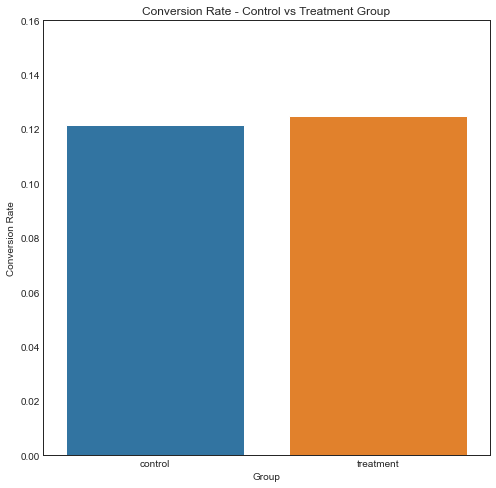

In [196]:
plt.figure(figsize=(8,8))
sns.set_style('white')
sns.barplot(x= ab_test_samples.group, y=ab_test_samples.converted, ci=False)
plt.ylim(0,.16)
plt.title('Conversion Rate - Control vs Treatment Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')
plt.show()

## 4. Test Results and Hypothesis
Calculate the z-statistic and pvalue of the test results to determine whether or not to reject the Null Hypothesis. 

In [197]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test_samples[ab_test_samples['group']== 'control']['converted']
treatment_results = ab_test_samples[ab_test_samples['group']== 'treatment']['converted']

In [198]:
n_size_control = control_results.count()
n_size_treatment = treatment_results.count()
n_size_total = [n_size_control , n_size_treatment]

converted_successes = [control_results.sum(), treatment_results.sum()]

# Calculate z-statistic and pvalue 
z_stat, pval = proportions_ztest(converted_successes, nobs = n_size_total)

# Calcualte confidence interval 
(lower_control, lower_treat), (upper_control, upper_treat) = proportion_confint(converted_successes, nobs = n_size_total, alpha = 0.05)

In [199]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_control:.3f}, {upper_control:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.50
p-value: 0.616
ci 95% for control group: [0.112, 0.131]
ci 95% for treatment group: [0.116, 0.134]


Based on p-value of 0.616 and our alpha threshold of 0.05, there's not enough evidence to suggest there was a significant change in conversion rates between the new page and old page. Therefore, I failed to reject the Null Hypothesis, which concules that the new page design did not show significant change to conversion compared to old page. 